# New Section

In [1]:
import pandas as pd

# Load the datasets
train_df = pd.read_csv('/train.csv')
test_df = pd.read_csv('/test.csv')
validation_df = pd.read_csv('/val.csv')

# Use only 30% of the training data
train_df = train_df.sample(frac=1.0, random_state=42)

# Separate features and target
X_train = train_df.drop(columns=['anomaly'])
y_train = train_df['anomaly']
X_test = test_df.drop(columns=['anomaly'])
y_test = test_df['anomaly']
X_validation = validation_df.drop(columns=['anomaly'])
y_validation = validation_df['anomaly']

# Columns
categorical_columns = ["Material number", "Supplier", "Contract", "Contract Position", "Procurement type",
                       "Special procurement type", "Dispatcher", "Buyer", "Purchasing group",
                       "Purchasing lot size", "Calendar", "Plant", "Plant information record",
                       "Information record number", "Information record type", "Product group",
                       "Base unit"]
numerical_columns = ["Fulfillment time", "Fixed contract 1", "Fixed contract 2", "Total quantity", "Total value",
                     "Price unit", "Plant processing time", "Material master time"]


In [2]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_num = scaler.fit_transform(X_train[numerical_columns])
X_test_num = scaler.transform(X_test[numerical_columns])
X_validation_num = scaler.transform(X_validation[numerical_columns])


In [3]:
from sklearn.preprocessing import LabelEncoder
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

# Combine all data to fit the label encoder
combined_cat = pd.concat([X_train[categorical_columns], X_test[categorical_columns], X_validation[categorical_columns]])

# Label encoding for categorical columns
label_encoders = {col: LabelEncoder().fit(combined_cat[col].astype(str)) for col in categorical_columns}

# Transform the data using the label encoders
X_train_cat_enc = np.stack([label_encoders[col].transform(X_train[col].astype(str)) for col in categorical_columns], axis=1)
X_test_cat_enc = np.stack([label_encoders[col].transform(X_test[col].astype(str)) for col in categorical_columns], axis=1)
X_validation_cat_enc = np.stack([label_encoders[col].transform(X_validation[col].astype(str)) for col in categorical_columns], axis=1)


In [4]:
# Autoencoder structure
input_dim = X_train_cat_enc.shape[1]
encoding_dim = 10  # Dimension of the encoded representation

input_layer = Input(shape=(input_dim,))
encoder = Dense(encoding_dim, activation="relu")(input_layer)
decoder = Dense(input_dim, activation="sigmoid")(encoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Train the autoencoder
autoencoder.fit(X_train_cat_enc, X_train_cat_enc,
                epochs=10,
                batch_size=256,
                shuffle=True,
                validation_split=0.2)

# Get the encoder part
encoder_model = Model(inputs=input_layer, outputs=encoder)

# Encode the categorical features
X_train_cat_enc = encoder_model.predict(X_train_cat_enc)
X_test_cat_enc = encoder_model.predict(X_test_cat_enc)
X_validation_cat_enc = encoder_model.predict(X_validation_cat_enc)


Epoch 1/10
497/497 [==============================] - 3s 3ms/step - loss: -797600896.0000 - val_loss: -2661810944.0000
Epoch 2/10
497/497 [==============================] - 1s 3ms/step - loss: -6627763200.0000 - val_loss: -11494593536.0000
Epoch 3/10
497/497 [==============================] - 1s 3ms/step - loss: -18469801984.0000 - val_loss: -26381330432.0000
Epoch 4/10
497/497 [==============================] - 1s 3ms/step - loss: -36081393664.0000 - val_loss: -46386704384.0000
Epoch 5/10
497/497 [==============================] - 1s 3ms/step - loss: -58271965184.0000 - val_loss: -70567985152.0000
Epoch 6/10
497/497 [==============================] - 1s 3ms/step - loss: -84466049024.0000 - val_loss: -98571239424.0000
Epoch 7/10
497/497 [==============================] - 1s 3ms/step - loss: -114336645120.0000 - val_loss: -130104492032.0000
Epoch 8/10
497/497 [==============================] - 2s 5ms/step - loss: -147656818688.0000 - val_loss: -164987060224.0000
Epoch 9/10
497/497 [====

In [5]:
# Combine the numerical and encoded categorical features
X_train_final = np.hstack((X_train_num, X_train_cat_enc))
X_test_final = np.hstack((X_test_num, X_test_cat_enc))
X_validation_final = np.hstack((X_validation_num, X_validation_cat_enc))


In [6]:
import xgboost as xgb
from sklearn.metrics import accuracy_score
import joblib

# Initialize the model
model = xgb.XGBClassifier()

# Train the model
model.fit(X_train_final, y_train)

# Predict and evaluate
y_pred = model.predict(X_test_final)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Save the model
joblib.dump(model, 'xgboost_model.joblib')


Accuracy: 0.835832083958021


['xgboost_model.joblib']

In [7]:
# Load the model
model = joblib.load('xgboost_model.joblib')

# Validate the model
y_val_pred = model.predict(X_validation_final)
val_accuracy = accuracy_score(y_validation, y_val_pred)
print(f"Validation Accuracy: {val_accuracy}")


Validation Accuracy: 0.8389376740201328


Top 5 features that show the most anomalies:
Fulfillment time
Buyer
Contract Position
Special procurement type
Plant processing time


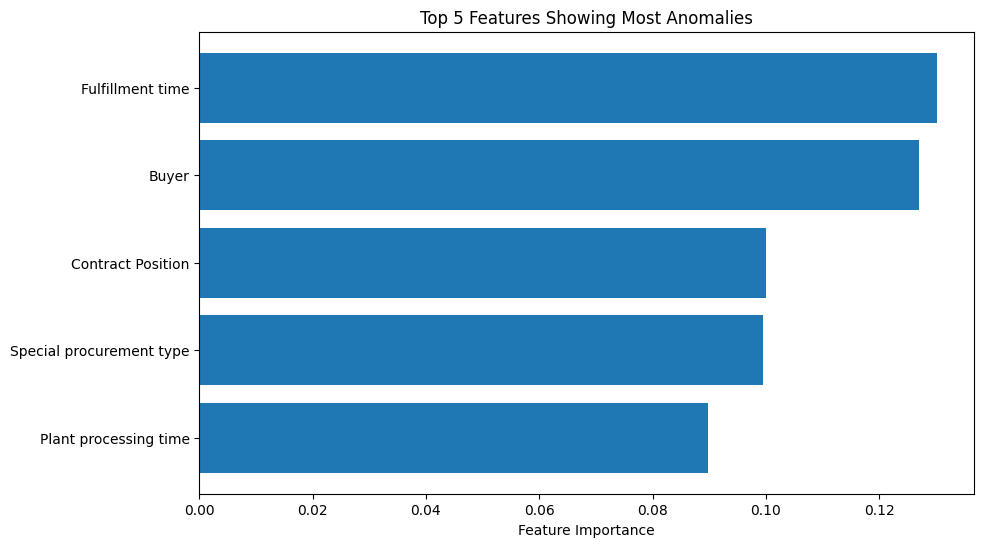

In [8]:
import xgboost as xgb
from sklearn.metrics import accuracy_score
import joblib
import numpy as np
import matplotlib.pyplot as plt

# Load the model
model = joblib.load('xgboost_model.joblib')

# Get feature importances
feature_importances = model.feature_importances_

# Combine feature names
feature_names = numerical_columns + categorical_columns

# Get the indices of the top 5 important features
top_5_indices = np.argsort(feature_importances)[-5:][::-1]

# Get the top 5 feature names
top_5_features = [feature_names[i] for i in top_5_indices]

print("Top 5 features that show the most anomalies:")
for feature in top_5_features:
    print(feature)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(range(5), feature_importances[top_5_indices], align='center')
plt.yticks(range(5), [feature_names[i] for i in top_5_indices])
plt.xlabel("Feature Importance")
plt.title("Top 5 Features Showing Most Anomalies")
plt.gca().invert_yaxis()
plt.show()


In [9]:
# Extract rows where anomaly label is 1
anomalies = train_df[train_df['anomaly'] == 1]

# Show examples of data from the top features
print(f"Examples of data from top features showing anomalies:")
print(anomalies[top_5_features].head())


Examples of data from top features showing anomalies:
        Fulfillment time  Buyer  Contract Position  Special procurement type  \
8693                   0  233.0                  0                      40.0   
153015                 0  211.0                  0                       NaN   
94224                  0  224.0                  0                      40.0   
126016                 0  203.0                  0                      41.0   
126763                 0  203.0                  0                       NaN   

        Plant processing time  
8693                        1  
153015                      1  
94224                       1  
126016                      1  
126763                      1  
